In [1]:
import time
import os
from random import shuffle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

We will load, preprocess and transfer all the data into one dataframe.  
We start with `Sync`, then `Spontan`, then `Alone`  

# Functions

In [2]:
def remove_duplicates_frame_id(attemp):
    start = time.time()
    remove = []
    keys = list(attemp.groupby('Frame_ID').groups.keys())
    values = list(attemp.groupby('Frame_ID').groups.values())
    
    for i in range(len(keys)):
        if len(values[i]) !=2:
            remove.append(keys[i])
    
    for i in range(len(remove)):
        temp = attemp[attemp.Frame_ID==remove[i]]
        attemp.drop(index=list(temp.index), inplace=True)
    
    attemp = attemp.reset_index().drop(columns='index')
    end = time.time()
    print('runtime:',end - start, 'seconds')
    return attemp

In [3]:
# Combine two consecutive rows into one
def combine_right_left(attemp):
    start = time.time()
    right_columns = ["{}{}".format(ind,'Right') for ind in attemp.columns]
    left_columns = ["{}{}".format(ind,'Left') for ind in attemp.columns]
    df = pd.DataFrame(columns=right_columns+left_columns)
    for i in range(0,len(attemp)-1,2):
        if i%10000==0: print(i)
        what = pd.Series(pd.concat([attemp.iloc[i],attemp.iloc[i+1]]))
        what.index = df.columns
        df.loc[i] = what
    df = df.reset_index().drop(columns='index')
    end = time.time()
    print('runtime:',end - start, 'seconds')
    return df

In [4]:
# Used for 'alone' datasets
def remove_unbalanced(temp):
    
    # Remove right hands from left dfs
    remove = temp[temp[' Hand Type']=='right']
    temp = temp.drop(index=list(remove.index))
    
    # Remove frames of two hands
    remove = temp[temp[' # hands']==2]
    temp = temp.drop(index=list(remove.index))
    return temp

# Used for 'alone' datasets
def create_df(left, right):
    final = pd.DataFrame(columns=right.columns)
    start = time.time()
    
    # Remove unbalanced frames from left
    if (len(left.groupby(' # hands').groups.keys()) != 1 or len(left[left[' Hand Type']=='right']) != 0):
        left = remove_unbalanced(left)

   # add up both dataframes into one
    for i in range(len(left)):
        if i>max(range(len(right))):
            break
        else:
            final = final.append(right.iloc[i])
            final = final.append(left.iloc[i])
    
    final = final.reset_index().drop(columns='index')

    # Match the 'Time' and 'Frame ID' columns
    for i in range(1, len(final),2): 
        final['Time'][i-1] = final['Time'][i]
        final[' Frame ID'][i-1] = final[' Frame ID'][i]
    
    end = time.time()
    print('runtime:',end - start, 'seconds')
    return final

# Train Sets

## Sync

### Load

In [5]:
path = r'data\hands\sync'
files = []
for file in os.listdir(path):
    files.append(os.path.join(path, file))

In [6]:
sync = pd.DataFrame()
for i in range(len(files)):
    temp = pd.read_csv(files[i])
    temp = temp[temp['Time']>temp['Time'][0]+7]
    sync = pd.concat([sync,temp])

### Preprocess

In [7]:
sync = sync.rename(columns={' Frame ID': 'Frame_ID', ' Hand Type': 'Hand_Type',
                     ' # hands':'Number_of_hands', ' Position X': 'Position_X', ' Position Y': 'Position_Y',
                     ' Position Z': 'Position_Z', ' Velocity X': 'Velocity_X', ' Velocity Y': 'Velocity_Y',
                     ' Velocity Z': 'Velocity_Z', ' Pitch' : 'Pitch',  ' Roll': 'Roll', ' Yaw': 'Yaw',
                     ' Wrist Pos X': 'Wrist_Pos_X', ' Wrist Pos Y': 'Wrist_Pos_Y', ' Wrist Pos Z': 'Wrist_Pos_Z',
                     ' Elbow pos X': 'Elbow_Pos_X',  ' Elbow Pos Y':  'Elbow_Pos_Y', ' Elbow Pos Z': 'Elbow_Pos_Z',
                     ' Grab Strenth': 'Grab_Strenth', ' Grab Angle': 'Grab_Angle',' Pinch Strength': 'Pinch_Strength'})

#### Are there unbalanced frames?

In [8]:
sync['Hand_Type'] = sync['Hand_Type'].map({'left':0, 'right':1})
sync = sync.reset_index().drop(columns='index')

In [9]:
sync.groupby('Number_of_hands').groups.keys()

dict_keys([1, 2])

In [10]:
temp = sync.groupby('Number_of_hands').get_group(1)

In [11]:
sync = sync.drop(index=list(temp.index))

#### Are there duplicates, NaN values?

In [12]:
sync = remove_duplicates_frame_id(sync)

runtime: 29.615626335144043 seconds


In [13]:
print(len(sync.groupby('Hand_Type').get_group(0)))
print(len(sync.groupby('Hand_Type').get_group(1)))

19638
19638


In [14]:
sync.duplicated().unique()

array([False])

In [15]:
sync.isna().sum()

Time               0
Frame_ID           0
Hand_Type          0
Number_of_hands    0
Position_X         0
Position_Y         0
Position_Z         0
Velocity_X         0
Velocity_Y         0
Velocity_Z         0
Pitch              0
Roll               0
Yaw                0
Wrist_Pos_X        0
Wrist_Pos_Y        0
Wrist_Pos_Z        0
Elbow_Pos_X        0
Elbow_Pos_Y        0
Elbow_Pos_Z        0
Grab_Strenth       0
Grab_Angle         0
Pinch_Strength     0
dtype: int64

### Label

In [16]:
sync['Category'] = 'sync'

In [17]:
sync

,Time,Frame_ID,Hand_Type,Number_of_hands,Position_X,Position_Y,Position_Z,Velocity_X,Velocity_Y,Velocity_Z,...,Wrist_Pos_X,Wrist_Pos_Y,Wrist_Pos_Z,Elbow_Pos_X,Elbow_Pos_Y,Elbow_Pos_Z,Grab_Strenth,Grab_Angle,Pinch_Strength,Category
0,434.2387,139878,1,2,121.96880,230.3867,61.918910,7.82505,-222.59100,121.91490,...,143.0681,170.9626,92.10286,290.9513,-17.46554,156.27410,0.0,0.036538,0.0,sync
1,434.2387,139878,0,2,-80.92312,284.2069,29.011070,84.47700,-45.59256,134.20850,...,-107.3702,221.7536,46.12994,-254.8560,22.47225,40.89467,0.0,0.000000,0.0,sync
2,434.2553,139880,1,2,121.61940,226.1235,64.109630,-32.32643,-248.08270,109.73410,...,143.3853,166.9691,94.34527,293.7114,-20.13464,156.68940,0.0,0.001488,0.0,sync
3,434.2553,139880,0,2,-79.71033,282.4789,31.691100,55.75132,-119.51820,158.45370,...,-106.8187,220.1253,48.09507,-258.4003,23.92692,43.43317,0.0,0.000000,0.0,sync
4,434.2718,139882,1,2,121.03880,222.2049,65.984120,-28.86916,-210.96420,109.70620,...,143.3656,163.3614,96.39383,296.6688,-21.13594,159.25370,0.0,0.000000,0.0,sync
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39271,856.2631,67309,1,2,101.91230,212.0264,42.535680,79.95810,113.41030,190.77140,...,131.8590,149.6264,66.09853,283.6185,-58.03491,95.29868,0.0,0.000000,0.0,sync
39272,856.2958,67311,0,2,-81.57359,183.5054,-7.185198,-63.24731,121.75270,62.95970,...,-109.7250,130.7078,34.03360,-295.5957,-14.97817,140.02630,0.0,0.000000,0.0,sync
39273,856.2958,67311,1,2,103.84750,214.7484,47.070820,61.11773,95.13531,155.74530,...,134.0416,151.5924,68.17693,288.9688,-54.13820,94.23959,0.0,0.000000,0.0,sync
39274,856.3295,67314,0,2,-84.05124,187.8450,-5.172269,-57.17249,109.20360,58.48146,...,-109.5167,131.6489,33.32945,-282.9649,-31.35462,135.07610,0.0,0.000000,0.0,sync


## Spontan

### Load

In [18]:
path = r'data\hands\spontan'
files = []
for file in os.listdir(path):
    files.append(os.path.join(path, file))

In [19]:
spontan = pd.DataFrame()
for i in range(len(files)):
    temp = pd.read_csv(files[i])
    temp = temp[temp['Time']>temp['Time'][0]+7]
    spontan = pd.concat([spontan,temp])

### Preprocess

In [20]:
spontan = spontan.rename(columns={' Frame ID': 'Frame_ID', ' Hand Type': 'Hand_Type',
                     ' # hands':'Number_of_hands', ' Position X': 'Position_X', ' Position Y': 'Position_Y',
                     ' Position Z': 'Position_Z', ' Velocity X': 'Velocity_X', ' Velocity Y': 'Velocity_Y',
                     ' Velocity Z': 'Velocity_Z', ' Pitch' : 'Pitch',  ' Roll': 'Roll', ' Yaw': 'Yaw',
                     ' Wrist Pos X': 'Wrist_Pos_X', ' Wrist Pos Y': 'Wrist_Pos_Y', ' Wrist Pos Z': 'Wrist_Pos_Z',
                     ' Elbow pos X': 'Elbow_Pos_X',  ' Elbow Pos Y':  'Elbow_Pos_Y', ' Elbow Pos Z': 'Elbow_Pos_Z',
                     ' Grab Strenth': 'Grab_Strenth', ' Grab Angle': 'Grab_Angle',' Pinch Strength': 'Pinch_Strength'})

#### Are there unbalanced frames?

In [21]:
spontan['Hand_Type'] = spontan['Hand_Type'].map({'left':0, 'right':1})
spontan = spontan.reset_index().drop(columns='index')

In [22]:
spontan.groupby('Number_of_hands').groups.keys()

dict_keys([1, 2])

In [23]:
temp = spontan.groupby('Number_of_hands').get_group(1)

In [24]:
spontan = spontan.drop(index=list(temp.index))

In [25]:
spontan = remove_duplicates_frame_id(spontan)

runtime: 33.3447151184082 seconds


In [26]:
print(len(spontan.groupby('Hand_Type').get_group(0)))
print(len(spontan.groupby('Hand_Type').get_group(1)))

16077
16077


#### Are there duplicates, NaN values?

In [27]:
spontan.duplicated().unique()

array([False])

In [28]:
spontan.isna().sum()

Time               0
Frame_ID           0
Hand_Type          0
Number_of_hands    0
Position_X         0
Position_Y         0
Position_Z         0
Velocity_X         0
Velocity_Y         0
Velocity_Z         0
Pitch              0
Roll               0
Yaw                0
Wrist_Pos_X        0
Wrist_Pos_Y        0
Wrist_Pos_Z        0
Elbow_Pos_X        0
Elbow_Pos_Y        0
Elbow_Pos_Z        0
Grab_Strenth       0
Grab_Angle         0
Pinch_Strength     0
dtype: int64

### Label

In [29]:
spontan['Category'] = 'spontan'

In [30]:
spontan

,Time,Frame_ID,Hand_Type,Number_of_hands,Position_X,Position_Y,Position_Z,Velocity_X,Velocity_Y,Velocity_Z,...,Wrist_Pos_X,Wrist_Pos_Y,Wrist_Pos_Z,Elbow_Pos_X,Elbow_Pos_Y,Elbow_Pos_Z,Grab_Strenth,Grab_Angle,Pinch_Strength,Category
0,343.0061,129364,1,2,152.31350,204.6813,-39.256710,-28.56766,23.00662,8.315823,...,191.4088,170.3479,8.976357,323.5327,21.27053,162.709900,1.000000,2.793122,0.329752,spontan
1,343.0061,129364,0,2,-102.28700,198.3166,-2.122641,-174.57210,379.14680,28.479910,...,-164.0542,164.5314,-1.686393,-322.2086,-30.71549,11.754400,0.000000,1.870325,0.000000,spontan
2,343.0227,129365,1,2,151.83340,204.4899,-39.084380,-54.05849,-21.54555,19.405560,...,190.8670,170.1528,9.191355,323.1941,20.16283,161.858900,1.000000,2.704073,0.293775,spontan
3,343.0227,129365,0,2,-103.87210,201.4944,-2.063620,-178.50250,357.85480,6.646493,...,-165.7898,168.1620,-2.054844,-318.4708,-31.61653,7.529989,0.000000,1.851572,0.000000,spontan
4,343.0392,129367,1,2,151.40560,203.4883,-38.142800,-14.11075,-56.44812,68.092860,...,190.4547,169.7302,10.512530,324.1130,19.09524,161.374600,1.000000,2.422549,0.175940,spontan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32149,672.3560,52394,0,2,-116.27840,224.4624,27.165140,-79.78110,-242.59920,212.571900,...,-131.9342,159.7603,55.760730,-299.2746,-23.78213,128.914700,0.000000,0.000000,0.000000,spontan
32150,672.3901,52398,1,2,173.10190,227.2133,13.619190,-112.81410,-48.35379,346.801300,...,213.1378,170.6027,36.332100,323.0024,-57.51204,90.513040,0.000000,0.203728,0.000000,spontan
32151,672.3901,52398,0,2,-116.97780,220.4245,25.342770,-45.61794,-68.81681,-39.436890,...,-126.6333,153.8205,51.225740,-300.8008,-23.95151,122.674400,0.000000,0.154418,0.204160,spontan
32152,673.4224,52505,1,2,145.75970,165.2668,-11.464750,91.24690,13.51082,-246.509300,...,198.7744,148.9755,36.172150,429.8078,88.65751,136.275900,0.000000,0.256132,0.000000,spontan


## Alone
First we have to preprocess the right hand before we concat with all th lefts

In [31]:
right = pd.read_csv(r'data\HandRight.csv')
right = right[right['Time']>right['Time'][0]+7]

In [32]:
right.groupby(' # hands').groups.keys()

dict_keys([1, 2])

In [33]:
temp = right.groupby(' # hands').get_group(2)
right = right.drop(index=list(temp.index))

In [34]:
temp = right.groupby(' Hand Type').get_group('left')
right = right.drop(index=list(temp.index))

In [35]:
right.duplicated().unique()

array([False])

In [36]:
right.isna().sum()

Time                 0
 Frame ID            0
 Hand Type           0
 # hands             0
 Position X          0
 Position Y          0
 Position Z          0
 Velocity X          0
 Velocity Y          0
 Velocity Z          0
 Pitch               0
 Roll                0
 Yaw                 0
 Wrist Pos X       384
 Wrist Pos Y       384
 Wrist Pos Z       384
 Elbow pos X       384
 Elbow Pos Y       384
 Elbow Pos Z       384
 Grab Strenth        0
 Grab Angle          0
 Pinch Strength      0
dtype: int64

There is too much missing values that cannot be filled with existing values.  
Therefore we have no other choice but delete them

In [37]:
right = right.dropna()

In [38]:
right = right.reset_index().drop(columns='index')

In [39]:
right

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,135.3024,16287,right,1,11.930320,199.9861,4.981665,-35.512210,-165.34660,-57.68153,...,-0.906612,75.457400,206.0521,45.38764,284.3946,140.01670,201.9318,0.0,0.561324,0.0
1,135.3194,16289,right,1,11.191900,195.3075,3.661716,-43.587440,-309.83740,-77.18515,...,-0.904311,74.461410,202.4562,44.28679,282.6278,140.97120,203.6773,0.0,0.626321,0.0
2,135.3357,16291,right,1,10.533080,189.0297,2.829388,-30.403600,-363.00330,-43.79815,...,-0.901862,73.600600,197.4387,43.54082,280.6384,142.54010,206.7526,0.0,0.636596,0.0
3,135.3524,16293,right,1,10.243000,181.9816,2.064330,-15.424000,-423.21200,-43.99948,...,-0.901268,73.195370,191.7202,42.73155,279.7357,148.13820,209.9330,0.0,0.701644,0.0
4,135.3690,16295,right,1,10.020610,174.8592,1.228467,-8.733602,-413.45130,-53.88054,...,-0.897777,72.686710,186.1613,41.98006,278.6890,152.52150,212.1112,0.0,0.786548,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3888,201.0806,23867,right,1,-8.623579,163.7605,207.301100,-271.901400,-12.95597,1133.33900,...,0.004875,5.541947,119.3280,267.78980,171.7839,-42.17188,410.2199,0.0,0.765803,0.0
3889,201.0967,23869,right,1,-13.097740,162.5545,225.698500,-266.212900,-102.12860,1029.19300,...,0.003377,1.698353,117.0805,285.09920,179.2368,-44.11964,413.5244,0.0,0.783391,0.0
3890,201.1133,23871,right,1,-16.722380,160.9650,240.584400,-192.594300,-87.53856,769.65150,...,0.004909,-1.484266,114.0260,298.58760,186.0559,-44.35751,415.7693,0.0,0.684677,0.0
3891,201.1299,23873,right,1,-19.684070,160.7849,251.099800,-158.997200,73.45740,557.20370,...,0.004470,-4.015731,112.9914,308.15980,190.9921,-42.38844,416.7549,0.0,0.591905,0.0


### Load

In [40]:
path = r'data\hands\alone'
files = []
for file in os.listdir(path):
    files.append(os.path.join(path, file))

In [41]:
alone = pd.DataFrame()
for i in range(len(files)):
    left = pd.read_csv(files[i])
    left = left[left['Time']>left['Time'][0]+7]
    alone = pd.concat([alone,create_df(left,right)])

runtime: 29.19702911376953 seconds
runtime: 26.223019123077393 seconds
runtime: 26.146040678024292 seconds
runtime: 28.903027772903442 seconds
runtime: 29.100213050842285 seconds
runtime: 29.035548448562622 seconds
runtime: 25.21487331390381 seconds
runtime: 13.520888566970825 seconds


In [42]:
backup = alone.copy()

In [43]:
alone = backup.copy()

### Preprocess

In [44]:
alone = alone.rename(columns={' Frame ID': 'Frame_ID', ' Hand Type': 'Hand_Type',
                     ' # hands':'Number_of_hands', ' Position X': 'Position_X', ' Position Y': 'Position_Y',
                     ' Position Z': 'Position_Z', ' Velocity X': 'Velocity_X', ' Velocity Y': 'Velocity_Y',
                     ' Velocity Z': 'Velocity_Z', ' Pitch' : 'Pitch',  ' Roll': 'Roll', ' Yaw': 'Yaw',
                     ' Wrist Pos X': 'Wrist_Pos_X', ' Wrist Pos Y': 'Wrist_Pos_Y', ' Wrist Pos Z': 'Wrist_Pos_Z',
                     ' Elbow pos X': 'Elbow_Pos_X',  ' Elbow Pos Y':  'Elbow_Pos_Y', ' Elbow Pos Z': 'Elbow_Pos_Z',
                     ' Grab Strenth': 'Grab_Strenth', ' Grab Angle': 'Grab_Angle',' Pinch Strength': 'Pinch_Strength'})

In [45]:
alone.groupby('Number_of_hands').groups.keys()

dict_keys([1])

In [46]:
alone['Hand_Type'] = alone['Hand_Type'].map({'left':0, 'right':1})
alone = alone.reset_index().drop(columns='index')

In [47]:
alone = remove_duplicates_frame_id(alone)

runtime: 32.62576103210449 seconds


In [48]:
print(len(alone.groupby('Hand_Type').get_group(0)))
print(len(alone.groupby('Hand_Type').get_group(1)))

18739
18739


In [49]:
alone['Frame_ID'] = alone.Frame_ID.astype(int)
alone['Hand_Type'] = alone.Hand_Type.astype(int)
alone['Number_of_hands'] = alone.Number_of_hands.astype(int)

### Label

In [50]:
alone['Category'] = 'alone'

In [51]:
alone

,Time,Frame_ID,Hand_Type,Number_of_hands,Position_X,Position_Y,Position_Z,Velocity_X,Velocity_Y,Velocity_Z,...,Wrist_Pos_X,Wrist_Pos_Y,Wrist_Pos_Z,Elbow_Pos_X,Elbow_Pos_Y,Elbow_Pos_Z,Grab_Strenth,Grab_Angle,Pinch_Strength,Category
0,525.8185,150428,1,1,11.93032,199.9861,4.981665,-35.512210,-165.346600,-57.68153,...,75.457400,206.0521,45.387640,284.3946,140.016700,201.931800,0.000000,0.561324,0.000000,alone
1,525.8185,150428,0,1,-52.96039,184.5535,-2.856696,162.152700,127.605200,-85.83782,...,-101.045500,132.5940,4.449887,-307.7127,-12.177800,5.125422,0.000000,0.073635,0.000000,alone
2,525.8351,150430,1,1,11.19190,195.3075,3.661716,-43.587440,-309.837400,-77.18515,...,74.461410,202.4562,44.286790,282.6278,140.971200,203.677300,0.000000,0.626321,0.000000,alone
3,525.8351,150430,0,1,-50.04434,185.5024,-4.845364,102.824800,-24.843370,-79.46504,...,-95.514710,131.5824,2.853924,-313.0367,3.746006,-0.704697,0.000000,0.018766,0.000000,alone
4,525.8516,150432,1,1,10.53308,189.0297,2.829388,-30.403600,-363.003300,-43.79815,...,73.600600,197.4387,43.540820,280.6384,142.540100,206.752600,0.000000,0.636596,0.000000,alone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37473,764.3589,59978,0,1,-127.69030,214.3489,17.686630,10.166750,-1.436222,32.29176,...,-144.053500,146.6893,41.966620,-245.5459,-85.746380,103.564600,0.075490,1.843212,0.084181,alone
37474,764.3913,59980,1,1,-22.11276,274.2728,31.415610,-8.843058,-83.212330,-639.75290,...,-3.440387,208.4963,66.675530,117.2093,48.328950,251.759400,0.000000,0.141693,0.000000,alone
37475,764.3913,59980,0,1,-127.03970,214.0473,18.497550,21.171390,-4.407517,23.76039,...,-143.884900,146.3207,42.219330,-249.2448,-83.668670,106.449700,0.097583,1.916124,0.128377,alone
37476,764.4246,59982,1,1,-21.76293,271.4360,20.731890,29.525320,-171.840700,-599.51820,...,-3.419981,207.1089,58.726220,115.2854,54.793040,251.534100,0.000000,0.143749,0.000000,alone


# Test Sets
I isolated one person from the train sets so they can act as a test set

## Sync

In [52]:
sync_test = pd.read_csv(r'data\hands\test\sync\Yael636771060699529085Sync.csv')
sync_test = sync_test[sync_test['Time']>sync_test['Time'][0]+7]

In [53]:
sync_test = sync_test.rename(columns={' Frame ID': 'Frame_ID', ' Hand Type': 'Hand_Type',
                     ' # hands':'Number_of_hands', ' Position X': 'Position_X', ' Position Y': 'Position_Y',
                     ' Position Z': 'Position_Z', ' Velocity X': 'Velocity_X', ' Velocity Y': 'Velocity_Y',
                     ' Velocity Z': 'Velocity_Z', ' Pitch' : 'Pitch',  ' Roll': 'Roll', ' Yaw': 'Yaw',
                     ' Wrist Pos X': 'Wrist_Pos_X', ' Wrist Pos Y': 'Wrist_Pos_Y', ' Wrist Pos Z': 'Wrist_Pos_Z',
                     ' Elbow pos X': 'Elbow_Pos_X',  ' Elbow Pos Y':  'Elbow_Pos_Y', ' Elbow Pos Z': 'Elbow_Pos_Z',
                     ' Grab Strenth': 'Grab_Strenth', ' Grab Angle': 'Grab_Angle',' Pinch Strength': 'Pinch_Strength'})

In [54]:
sync_test['Hand_Type'] = sync_test['Hand_Type'].map({'left':0, 'right':1})
sync_test = sync_test.reset_index().drop(columns='index')

In [55]:
sync_test.groupby('Number_of_hands').groups.keys()

dict_keys([1, 2])

In [56]:
sync_test = remove_duplicates_frame_id(sync_test)

runtime: 0.2835710048675537 seconds


In [57]:
print(len(sync_test.groupby('Hand_Type').get_group(0)))
print(len(sync_test.groupby('Hand_Type').get_group(1)))

3879
3879


In [58]:
sync_test['Category'] = 'sync'

In [59]:
sync_test

,Time,Frame_ID,Hand_Type,Number_of_hands,Position_X,Position_Y,Position_Z,Velocity_X,Velocity_Y,Velocity_Z,...,Wrist_Pos_X,Wrist_Pos_Y,Wrist_Pos_Z,Elbow_Pos_X,Elbow_Pos_Y,Elbow_Pos_Z,Grab_Strenth,Grab_Angle,Pinch_Strength,Category
0,298.0274,34883,1,2,141.2564,189.2216,-33.959570,-38.242280,-131.06840,-65.171680,...,168.6781,147.01750,16.225870,293.7376,-42.78623,124.49290,0.0,0.000000,0.0,sync
1,298.0274,34883,0,2,-147.0786,224.8429,7.665721,-49.093820,26.32365,-23.403670,...,-169.7281,157.92900,4.217278,-308.4872,-48.70331,42.11309,0.0,0.000000,0.0,sync
2,298.0442,34885,1,2,140.5700,186.6451,-34.894930,-44.761110,-154.15820,-55.219710,...,168.3989,145.39570,15.869250,294.6779,-40.69072,129.06170,0.0,0.000000,0.0,sync
3,298.0442,34885,0,2,-148.0286,225.0952,7.201766,-66.796850,22.21177,-27.387280,...,-169.6996,157.77930,4.369710,-303.6758,-52.50298,39.28092,0.0,0.000000,0.0,sync
4,298.0606,34887,1,2,140.4275,184.7218,-36.126540,3.861293,-88.91689,-80.044560,...,168.3059,144.48790,15.427030,297.3559,-36.36649,133.85370,0.0,0.000000,0.0,sync
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7753,365.9673,42714,0,2,-127.2811,137.6471,-55.658230,60.419170,-402.94580,99.212360,...,-157.1180,101.79940,-3.860802,-356.9034,50.44975,136.61840,0.0,0.102073,0.0,sync
7754,365.9842,42716,1,2,105.8573,203.8846,-40.742390,38.903880,73.38232,75.832130,...,137.2473,142.04170,-45.929200,226.1846,-67.83814,55.68773,0.0,0.000000,0.0,sync
7755,365.9842,42716,0,2,-126.1666,130.8461,-54.101770,93.572760,-388.12690,62.157910,...,-155.3881,95.57278,-1.611514,-352.0472,50.69477,145.34620,0.0,0.095909,0.0,sync
7756,366.0006,42718,1,2,105.9873,204.8087,-38.943860,-3.431330,47.85580,110.779000,...,137.7608,143.67720,-47.348780,232.7063,-63.07462,55.24001,0.0,0.019550,0.0,sync


## Spontan

In [60]:
spontan_test = pd.read_csv(r'data\hands\test\spontan\Yael636771059544754823Spontan.csv')
spontan_test = spontan_test[spontan_test['Time']>spontan_test['Time'][0]+7]

In [61]:
spontan_test = spontan_test.rename(columns={' Frame ID': 'Frame_ID', ' Hand Type': 'Hand_Type',
                     ' # hands':'Number_of_hands', ' Position X': 'Position_X', ' Position Y': 'Position_Y',
                     ' Position Z': 'Position_Z', ' Velocity X': 'Velocity_X', ' Velocity Y': 'Velocity_Y',
                     ' Velocity Z': 'Velocity_Z', ' Pitch' : 'Pitch',  ' Roll': 'Roll', ' Yaw': 'Yaw',
                     ' Wrist Pos X': 'Wrist_Pos_X', ' Wrist Pos Y': 'Wrist_Pos_Y', ' Wrist Pos Z': 'Wrist_Pos_Z',
                     ' Elbow pos X': 'Elbow_Pos_X',  ' Elbow Pos Y':  'Elbow_Pos_Y', ' Elbow Pos Z': 'Elbow_Pos_Z',
                     ' Grab Strenth': 'Grab_Strenth', ' Grab Angle': 'Grab_Angle',' Pinch Strength': 'Pinch_Strength'})

In [62]:
spontan_test['Hand_Type'] = spontan_test['Hand_Type'].map({'left':0, 'right':1})
spontan_test = spontan_test.reset_index().drop(columns='index')

In [63]:
spontan_test.groupby('Number_of_hands').groups.keys()

dict_keys([1, 2])

In [64]:
temp = spontan_test.groupby('Number_of_hands').get_group(1)
spontan_test = spontan_test.drop(index=list(temp.index))

In [65]:
spontan_test = remove_duplicates_frame_id(spontan_test)

runtime: 0.041678667068481445 seconds


In [66]:
print(len(spontan_test.groupby('Hand_Type').get_group(0)))
print(len(spontan_test.groupby('Hand_Type').get_group(1)))

3823
3823


In [67]:
spontan_test['Category'] = 'spontan'

In [68]:
spontan_test

,Time,Frame_ID,Hand_Type,Number_of_hands,Position_X,Position_Y,Position_Z,Velocity_X,Velocity_Y,Velocity_Z,...,Wrist_Pos_X,Wrist_Pos_Y,Wrist_Pos_Z,Elbow_Pos_X,Elbow_Pos_Y,Elbow_Pos_Z,Grab_Strenth,Grab_Angle,Pinch_Strength,Category
0,182.5492,21577,1,2,164.7270,207.8432,-41.85309,31.496850,-56.75478,9.316936,...,209.5091,172.55970,-2.273207,342.2353,15.955520,134.07660,0.0,1.476075,1.00000,spontan
1,182.5492,21577,0,2,-161.9303,215.8074,99.36817,12.804610,-43.17722,-168.687000,...,-219.6073,178.00230,99.639580,-363.6586,-19.022130,133.74230,0.0,0.567723,0.00000,spontan
2,182.5659,21579,1,2,164.9208,206.6411,-41.74547,-1.715062,-77.52304,5.922840,...,210.0906,172.09180,-1.983218,342.6916,16.185780,135.29430,0.0,1.474956,1.00000,spontan
3,182.5659,21579,0,2,-161.3204,214.3152,96.38842,20.128390,-83.41072,-164.680200,...,-218.7959,176.09240,97.700950,-369.2605,-14.169510,141.24010,0.0,0.627632,0.00000,spontan
4,182.5823,21581,1,2,164.4858,205.1424,-41.73409,-33.584710,-89.86977,-0.667350,...,210.3185,171.51130,-1.979968,343.1189,16.282490,135.87790,0.0,1.474284,1.00000,spontan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7641,250.4891,29408,0,2,-182.5847,163.6456,-68.80135,-35.421390,116.10120,-69.644100,...,-197.3056,99.21357,-46.785290,-187.7603,-101.385700,100.04830,0.0,2.386132,1.00000,spontan
7642,250.5056,29410,1,2,188.6473,272.1407,12.92494,-78.759040,41.62151,152.617500,...,218.4793,209.26900,20.160720,301.2075,-5.964263,113.55220,0.0,0.000000,0.00000,spontan
7643,250.5056,29410,0,2,-183.6162,166.2290,-70.81329,-68.142180,149.32880,-127.051700,...,-198.4732,102.11860,-47.912580,-187.7793,-99.725160,97.12544,0.0,2.399800,1.00000,spontan
7644,250.5222,29412,1,2,185.7756,270.9572,14.97516,-149.457700,-80.24364,109.999700,...,216.1146,208.23930,21.901190,303.5852,-8.788544,106.39420,0.0,0.000000,0.00000,spontan


## Alone

In [69]:
left = pd.read_csv(r'data\hands\test\alone\Yael636771061659067649Alone.csv')
left = left[left['Time']>left['Time'][0]+7]
alone_test = pd.DataFrame(columns=right.columns)
alone_test = pd.concat([alone_test,create_df(left,right)])

runtime: 28.964279174804688 seconds


In [70]:
alone_test = alone_test.rename(columns={' Frame ID': 'Frame_ID', ' Hand Type': 'Hand_Type',
                     ' # hands':'Number_of_hands', ' Position X': 'Position_X', ' Position Y': 'Position_Y',
                     ' Position Z': 'Position_Z', ' Velocity X': 'Velocity_X', ' Velocity Y': 'Velocity_Y',
                     ' Velocity Z': 'Velocity_Z', ' Pitch' : 'Pitch',  ' Roll': 'Roll', ' Yaw': 'Yaw',
                     ' Wrist Pos X': 'Wrist_Pos_X', ' Wrist Pos Y': 'Wrist_Pos_Y', ' Wrist Pos Z': 'Wrist_Pos_Z',
                     ' Elbow pos X': 'Elbow_Pos_X',  ' Elbow Pos Y':  'Elbow_Pos_Y', ' Elbow Pos Z': 'Elbow_Pos_Z',
                     ' Grab Strenth': 'Grab_Strenth', ' Grab Angle': 'Grab_Angle',' Pinch Strength': 'Pinch_Strength'})

In [71]:
alone_test.groupby('Number_of_hands').groups.keys()

dict_keys([1])

In [72]:
alone_test['Hand_Type'] = alone_test['Hand_Type'].map({'left':0, 'right':1})
alone_test= alone_test.reset_index().drop(columns='index')

In [73]:
alone_test = remove_duplicates_frame_id(alone_test)

runtime: 0.09731268882751465 seconds


In [74]:
print(len(alone_test.groupby('Hand_Type').get_group(0)))
print(len(alone_test.groupby('Hand_Type').get_group(1)))

3893
3893


In [75]:
alone_test['Frame_ID'] = alone_test.Frame_ID.astype(int)
alone_test['Hand_Type'] = alone_test.Hand_Type.astype(int)
alone_test['Number_of_hands'] = alone_test.Number_of_hands.astype(int)

In [76]:
alone_test['Category'] = 'alone'

In [77]:
alone_test

,Time,Frame_ID,Hand_Type,Number_of_hands,Position_X,Position_Y,Position_Z,Velocity_X,Velocity_Y,Velocity_Z,...,Wrist_Pos_X,Wrist_Pos_Y,Wrist_Pos_Z,Elbow_Pos_X,Elbow_Pos_Y,Elbow_Pos_Z,Grab_Strenth,Grab_Angle,Pinch_Strength,Category
0,393.9650,45942,1,1,11.93032,199.9861,4.981665,-35.51221,-165.34660,-57.681530,...,75.457400,206.0521,45.38764,284.3946,140.016700,201.93180,0.0,0.561324,0.0,alone
1,393.9650,45942,0,1,-132.48820,167.2630,-109.403700,-101.48310,120.36350,53.024990,...,-164.216200,121.3685,-67.14175,-350.5624,-2.776089,43.12173,0.0,0.000000,0.0,alone
2,393.9816,45944,1,1,11.19190,195.3075,3.661716,-43.58744,-309.83740,-77.185150,...,74.461410,202.4562,44.28679,282.6278,140.971200,203.67730,0.0,0.626321,0.0,alone
3,393.9816,45944,0,1,-133.29310,170.1855,-110.044200,-50.03410,194.50440,-70.430000,...,-163.284500,124.2790,-66.48141,-340.4475,-4.599389,53.09456,0.0,0.000000,0.0,alone
4,393.9982,45946,1,1,10.53308,189.0297,2.829388,-30.40360,-363.00330,-43.798150,...,73.600600,197.4387,43.54082,280.6384,142.540100,206.75260,0.0,0.636596,0.0,alone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7781,459.6741,53514,0,1,-115.83710,175.4736,-78.363170,14.19097,19.36646,0.649988,...,-152.741800,163.1568,-21.18231,-203.5265,-5.079565,156.00090,0.0,0.000000,0.0,alone
7782,459.6907,53516,1,1,-19.68407,160.7849,251.099800,-158.99720,73.45740,557.203700,...,-4.015731,112.9914,308.15980,190.9921,-42.388440,416.75490,0.0,0.591905,0.0,alone
7783,459.6907,53516,0,1,-115.59610,176.1113,-78.459830,17.12207,37.51048,-7.901237,...,-152.499100,163.3465,-21.37673,-201.3839,-5.142684,156.10030,0.0,0.000000,0.0,alone
7784,459.7072,53517,1,1,-22.06109,161.7254,260.237800,-130.15110,32.14947,516.023300,...,-5.931119,113.1688,316.40630,195.0999,-39.386570,417.62440,0.0,0.407940,0.0,alone


# Validation Sets

# Sync

In [78]:
path = r'data\hands\validation\sync'
files = []
for file in os.listdir(path):
    files.append(os.path.join(path, file))

sync_valid = pd.DataFrame()
for i in range(len(files)):
    temp = pd.read_csv(files[i])
    temp = temp[temp['Time']>temp['Time'][0]+7]
    sync_valid = pd.concat([sync_valid,temp])

In [79]:
sync_valid = sync_valid.rename(columns={' Frame ID': 'Frame_ID', ' Hand Type': 'Hand_Type',
                     ' # hands':'Number_of_hands', ' Position X': 'Position_X', ' Position Y': 'Position_Y',
                     ' Position Z': 'Position_Z', ' Velocity X': 'Velocity_X', ' Velocity Y': 'Velocity_Y',
                     ' Velocity Z': 'Velocity_Z', ' Pitch' : 'Pitch',  ' Roll': 'Roll', ' Yaw': 'Yaw',
                     ' Wrist Pos X': 'Wrist_Pos_X', ' Wrist Pos Y': 'Wrist_Pos_Y', ' Wrist Pos Z': 'Wrist_Pos_Z',
                     ' Elbow pos X': 'Elbow_Pos_X',  ' Elbow Pos Y':  'Elbow_Pos_Y', ' Elbow Pos Z': 'Elbow_Pos_Z',
                     ' Grab Strenth': 'Grab_Strenth', ' Grab Angle': 'Grab_Angle',' Pinch Strength': 'Pinch_Strength'})
sync_valid['Hand_Type'] = sync_valid['Hand_Type'].map({'left':0, 'right':1})
sync_valid = sync_valid.reset_index().drop(columns='index')

In [80]:
sync_valid.groupby('Number_of_hands').groups.keys()

dict_keys([1, 2])

In [81]:
temp = sync_valid.groupby('Number_of_hands').get_group(1)
sync_valid = sync_valid.drop(index=list(temp.index))

In [82]:
sync_valid = remove_duplicates_frame_id(sync_valid)

runtime: 0.08571910858154297 seconds


In [83]:
print(len(sync_valid.groupby('Hand_Type').get_group(0)))
print(len(sync_valid.groupby('Hand_Type').get_group(1)))

9957
9957


In [84]:
sync_valid['Category'] = 'sync'

In [85]:
sync_valid

,Time,Frame_ID,Hand_Type,Number_of_hands,Position_X,Position_Y,Position_Z,Velocity_X,Velocity_Y,Velocity_Z,...,Wrist_Pos_X,Wrist_Pos_Y,Wrist_Pos_Z,Elbow_Pos_X,Elbow_Pos_Y,Elbow_Pos_Z,Grab_Strenth,Grab_Angle,Pinch_Strength,Category
0,873.0052,101916,1,2,125.67840,232.6640,5.539143,-203.14320,404.92760,142.52930,...,126.7503,179.9287,47.80795,222.4352,19.06148,198.3806,0.0,0.000000,0.0,sync
1,873.0052,101916,0,2,-165.54570,210.9649,34.544110,-20.78199,141.12930,158.17200,...,-184.7836,150.3946,57.01332,-323.1411,-12.50550,166.6798,0.0,0.000000,0.0,sync
2,873.0218,101918,1,2,121.96130,238.2120,8.282627,-180.92320,336.21880,176.34840,...,124.2761,183.5448,48.00742,222.1145,14.49698,187.8518,0.0,0.000000,0.0,sync
3,873.0218,101918,0,2,-166.27120,213.6761,37.096450,-41.68034,146.74810,152.49840,...,-184.3011,152.1136,57.66708,-320.6704,-13.19601,166.2126,0.0,0.000000,0.0,sync
4,873.0384,101919,1,2,120.59450,240.5899,10.272620,-157.77620,274.48410,229.71140,...,123.1464,184.8697,48.46577,223.1355,13.36058,183.7166,0.0,0.000000,0.0,sync
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19909,998.8158,66221,0,2,-96.74767,323.8981,76.983160,27.14988,185.62180,33.74187,...,-145.1963,267.8716,68.90888,-298.0420,57.52314,124.0967,0.0,0.075099,0.0,sync
19910,998.8495,66224,1,2,111.83100,324.5124,102.834100,86.42312,119.68330,-13.67371,...,163.0329,269.7217,103.07490,340.7914,72.96347,121.5707,0.0,0.024162,0.0,sync
19911,998.8495,66224,0,2,-95.67720,329.8123,78.133160,47.37696,118.31670,24.15247,...,-143.7923,273.4537,69.90453,-300.8497,65.10999,120.6967,0.0,0.029208,0.0,sync
19912,998.8855,66227,1,2,113.80260,325.5213,101.486000,54.98372,11.75017,-37.26006,...,165.0616,270.7919,101.25900,344.8011,75.97822,121.1411,0.0,0.025365,0.0,sync


# Spontan

In [86]:
path = r'data\hands\validation\spontan'
files = []
for file in os.listdir(path):
    files.append(os.path.join(path, file))

spontan_valid = pd.DataFrame()
for i in range(len(files)):
    temp = pd.read_csv(files[i])
    temp = temp[temp['Time']>temp['Time'][0]+7]
    spontan_valid = pd.concat([spontan_valid,temp])

In [87]:
spontan_valid = spontan_valid.rename(columns={' Frame ID': 'Frame_ID', ' Hand Type': 'Hand_Type',
                     ' # hands':'Number_of_hands', ' Position X': 'Position_X', ' Position Y': 'Position_Y',
                     ' Position Z': 'Position_Z', ' Velocity X': 'Velocity_X', ' Velocity Y': 'Velocity_Y',
                     ' Velocity Z': 'Velocity_Z', ' Pitch' : 'Pitch',  ' Roll': 'Roll', ' Yaw': 'Yaw',
                     ' Wrist Pos X': 'Wrist_Pos_X', ' Wrist Pos Y': 'Wrist_Pos_Y', ' Wrist Pos Z': 'Wrist_Pos_Z',
                     ' Elbow pos X': 'Elbow_Pos_X',  ' Elbow Pos Y':  'Elbow_Pos_Y', ' Elbow Pos Z': 'Elbow_Pos_Z',
                     ' Grab Strenth': 'Grab_Strenth', ' Grab Angle': 'Grab_Angle',' Pinch Strength': 'Pinch_Strength'})
spontan_valid['Hand_Type'] = spontan_valid['Hand_Type'].map({'left':0, 'right':1})
spontan_valid = spontan_valid.reset_index().drop(columns='index')

In [88]:
spontan_valid.groupby('Number_of_hands').groups.keys()

dict_keys([1, 2])

In [89]:
temp = spontan_valid.groupby('Number_of_hands').get_group(1)
spontan_valid = spontan_valid.drop(index=list(temp.index))

In [90]:
spontan_valid = remove_duplicates_frame_id(spontan_valid)

runtime: 0.12922072410583496 seconds


In [91]:
print(len(spontan_valid.groupby('Hand_Type').get_group(0)))
print(len(spontan_valid.groupby('Hand_Type').get_group(1)))

10181
10181


In [92]:
spontan_valid['Category'] = 'spontan'

In [93]:
spontan_valid

,Time,Frame_ID,Hand_Type,Number_of_hands,Position_X,Position_Y,Position_Z,Velocity_X,Velocity_Y,Velocity_Z,...,Wrist_Pos_X,Wrist_Pos_Y,Wrist_Pos_Z,Elbow_Pos_X,Elbow_Pos_Y,Elbow_Pos_Z,Grab_Strenth,Grab_Angle,Pinch_Strength,Category
0,779.2876,91127,1,2,138.8987,208.2936,-19.50835,41.916630,138.348200,104.167200,...,164.3573,159.7095,25.43896,243.8085,-34.596770,163.7492,0.0,0.000000,0.000000,spontan
1,779.2876,91127,0,2,-159.3453,203.1198,28.14956,1.868645,37.016940,-11.420150,...,-213.8900,177.1807,64.79929,-448.8590,123.886300,136.5380,1.0,2.590619,0.653887,spontan
2,779.3041,91129,1,2,140.0173,210.8828,-17.73810,77.056050,164.873100,96.788050,...,165.6616,161.6832,26.45107,247.7545,-32.000530,164.0902,0.0,0.000000,0.000000,spontan
3,779.3041,91129,0,2,-158.8304,202.9772,27.92949,41.384500,-18.251300,-16.370260,...,-213.3517,177.8003,65.14764,-448.3777,124.648900,136.8058,1.0,2.661068,0.763163,spontan
4,779.3207,91131,1,2,141.3535,213.6528,-16.16991,68.159450,146.879500,85.529340,...,167.0913,164.0732,27.55513,251.2191,-29.175110,164.5763,0.0,0.000000,0.000000,spontan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20357,891.7819,58583,0,2,-120.5057,263.0826,88.22878,-21.621920,-62.061390,-9.631733,...,-165.0284,214.7203,120.74640,-331.0928,27.694880,191.2160,0.0,0.061163,0.000000,spontan
20358,891.8161,58585,1,2,267.8961,299.6111,119.21900,15.681960,76.817810,356.734300,...,272.7868,227.7773,106.85620,384.1153,-6.891727,114.2839,0.0,0.104950,0.000000,spontan
20359,891.8161,58585,0,2,-121.2682,261.9093,88.43225,-38.911430,-56.677020,15.780990,...,-165.7346,213.5043,120.97480,-333.9048,28.011810,190.4738,0.0,0.066622,0.000000,spontan
20360,891.8492,58589,1,2,266.2651,301.0812,133.05060,-109.071700,-4.087156,299.358300,...,275.7412,230.0791,118.34110,390.4021,-3.014284,112.5219,0.0,0.077156,0.000000,spontan


# Alone

In [94]:
path = r'data\hands\validation\alone'
files = []
for file in os.listdir(path):
    files.append(os.path.join(path, file))

alone_valid = pd.DataFrame()
for i in range(len(files)):
    left = pd.read_csv(files[i])
    left = left[left['Time']>left['Time'][0]+7]
    alone_valid = pd.concat([alone_valid,create_df(left,right)])

runtime: 28.519943237304688 seconds
runtime: 29.071605920791626 seconds
runtime: 13.703841209411621 seconds


In [95]:
alone_valid = alone_valid.rename(columns={' Frame ID': 'Frame_ID', ' Hand Type': 'Hand_Type',
                     ' # hands':'Number_of_hands', ' Position X': 'Position_X', ' Position Y': 'Position_Y',
                     ' Position Z': 'Position_Z', ' Velocity X': 'Velocity_X', ' Velocity Y': 'Velocity_Y',
                     ' Velocity Z': 'Velocity_Z', ' Pitch' : 'Pitch',  ' Roll': 'Roll', ' Yaw': 'Yaw',
                     ' Wrist Pos X': 'Wrist_Pos_X', ' Wrist Pos Y': 'Wrist_Pos_Y', ' Wrist Pos Z': 'Wrist_Pos_Z',
                     ' Elbow pos X': 'Elbow_Pos_X',  ' Elbow Pos Y':  'Elbow_Pos_Y', ' Elbow Pos Z': 'Elbow_Pos_Z',
                     ' Grab Strenth': 'Grab_Strenth', ' Grab Angle': 'Grab_Angle',' Pinch Strength': 'Pinch_Strength'})

In [96]:
alone_valid.groupby('Number_of_hands').groups.keys()

dict_keys([1])

In [97]:
alone_valid['Hand_Type'] = alone_valid['Hand_Type'].map({'left':0, 'right':1})
alone_valid = alone_valid.reset_index().drop(columns='index')

In [98]:
alone_valid = remove_duplicates_frame_id(alone_valid)

runtime: 0.14500737190246582 seconds


In [99]:
print(len(alone_valid.groupby('Hand_Type').get_group(0)))
print(len(alone_valid.groupby('Hand_Type').get_group(1)))

9751
9751


In [100]:
alone_valid['Frame_ID'] = alone_valid.Frame_ID.astype(int)
alone_valid['Hand_Type'] = alone_valid.Hand_Type.astype(int)
alone_valid['Number_of_hands'] = alone_valid.Number_of_hands.astype(int)

In [101]:
alone_valid['Category'] = 'alone'

In [102]:
alone_valid

,Time,Frame_ID,Hand_Type,Number_of_hands,Position_X,Position_Y,Position_Z,Velocity_X,Velocity_Y,Velocity_Z,...,Wrist_Pos_X,Wrist_Pos_Y,Wrist_Pos_Z,Elbow_Pos_X,Elbow_Pos_Y,Elbow_Pos_Z,Grab_Strenth,Grab_Angle,Pinch_Strength,Category
0,962.0724,112175,1,1,11.93032,199.9861,4.981665,-35.51221,-165.34660,-57.681530,...,75.457400,206.0521,45.38764,284.3946,140.01670,201.9318,0.0,0.561324,0.0,alone
1,962.0724,112175,0,1,-139.56040,289.5980,55.820400,85.41927,-314.15190,-17.789130,...,-200.491400,261.7830,63.46514,-379.1310,110.43980,116.0856,0.0,0.911471,0.0,alone
2,962.0892,112177,1,1,11.19190,195.3075,3.661716,-43.58744,-309.83740,-77.185150,...,74.461410,202.4562,44.28679,282.6278,140.97120,203.6773,0.0,0.626321,0.0,alone
3,962.0892,112177,0,1,-137.84700,284.6244,55.608300,98.89174,-268.35150,-9.115684,...,-199.076000,257.3272,63.25856,-383.5433,112.63620,114.6168,0.0,0.909256,0.0,alone
4,962.1058,112179,1,1,10.53308,189.0297,2.829388,-30.40360,-363.00330,-43.798150,...,73.600600,197.4387,43.54082,280.6384,142.54010,206.7526,0.0,0.636596,0.0,alone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19497,796.8187,50333,0,1,-65.33954,272.7191,59.171990,-27.79678,-111.88810,-42.745720,...,-108.317300,220.3898,88.81828,-290.7480,44.09612,152.9062,0.0,0.304604,0.0,alone
19498,796.8510,50336,1,1,-18.48622,254.1662,-6.611301,81.55730,-430.96530,-466.307100,...,-1.458149,194.7153,39.20568,109.6707,59.98541,248.8821,0.0,0.163980,0.0,alone
19499,796.8510,50336,0,1,-67.02361,268.6757,57.914730,-31.61606,-76.33112,-24.734110,...,-108.715100,215.5677,88.03761,-285.7091,36.18958,158.4956,0.0,0.374116,0.0,alone
19500,796.8842,50338,1,1,-16.98820,245.2297,-13.919220,97.62247,-530.35250,-399.822800,...,-0.297614,187.5606,34.26722,107.8837,57.63274,248.4669,0.0,0.163693,0.0,alone


# Final Load
Concating all train sets, test sets and validation sets  
But before I have to 'combine' any two consecutive rows into one in each data set:  
Time, Frame_ID and Number_of_hands mean nothing to us so we can safely remove them.

In [103]:
syncx = combine_right_left(sync.drop(columns=['Time','Frame_ID','Hand_Type','Number_of_hands','Category']))
print('***')
sync_testx = combine_right_left(sync_test.drop(columns=['Time','Frame_ID','Hand_Type','Number_of_hands','Category']))
print('***')
sync_validx = combine_right_left(sync_valid.drop(columns=['Time','Frame_ID','Hand_Type','Number_of_hands','Category']))

0
10000
20000
30000
runtime: 39.694966077804565 seconds
***
0
runtime: 4.279020309448242 seconds
***
0
10000
runtime: 14.627772569656372 seconds


In [104]:
spontanx = combine_right_left(spontan.drop(columns=['Time','Frame_ID','Hand_Type','Number_of_hands','Category']))
print('***')
spontan_testx = combine_right_left(spontan_test.drop(columns=['Time','Frame_ID','Hand_Type','Number_of_hands','Category']))
print('***')
spontan_validx = combine_right_left(spontan_valid.drop(columns=['Time','Frame_ID','Hand_Type','Number_of_hands','Category']))

0
10000
20000
30000
runtime: 29.673646211624146 seconds
***
0
runtime: 4.0846827030181885 seconds
***
0
10000
20000
runtime: 15.080662488937378 seconds


In [105]:
alonex = combine_right_left(alone.drop(columns=['Time','Frame_ID','Hand_Type','Number_of_hands','Category']))
print('***')
alone_testx = combine_right_left(alone_test.drop(columns=['Time','Frame_ID','Hand_Type','Number_of_hands','Category']))
print('***')
alone_validx = combine_right_left(alone_valid.drop(columns=['Time','Frame_ID','Hand_Type','Number_of_hands','Category']))

0
10000
20000
30000
runtime: 37.3043794631958 seconds
***
0
runtime: 4.142212867736816 seconds
***
0
10000
runtime: 14.375058889389038 seconds


Adding labels:

In [106]:
syncx['Category'] = 'sync'
sync_testx['Category'] = 'sync'
sync_validx['Category'] = 'sync'

spontanx['Category'] = 'spontan'
spontan_testx['Category'] = 'spontan'
spontan_validx['Category'] = 'spontan'

alonex['Category'] = 'alone'
alone_testx['Category'] = 'alone'
alone_validx['Category'] = 'alone'

In [107]:
train = pd.concat([syncx,spontanx, alonex])
train['Category'] = train['Category'].map({'sync':0, 'spontan':1, 'alone':2})
#train = train.reset_index().drop(columns='index')
train = train.sample(frac=1).reset_index().drop(columns='index')

test = pd.concat([sync_testx,spontan_testx, alone_testx])
test['Category'] = test['Category'].map({'sync':0, 'spontan':1, 'alone':2})
#test = test.reset_index().drop(columns='index')
test = test.sample(frac=1).reset_index().drop(columns='index')

valid = pd.concat([sync_validx,spontan_validx, alone_validx])
valid['Category'] = valid['Category'].map({'sync':0, 'spontan':1, 'alone':2})
#valid = valid.reset_index().drop(columns='index')
valid = valid.sample(frac=1).reset_index().drop(columns='index')

# A bit of visualization

#### Do people follow the same patterns of body language?

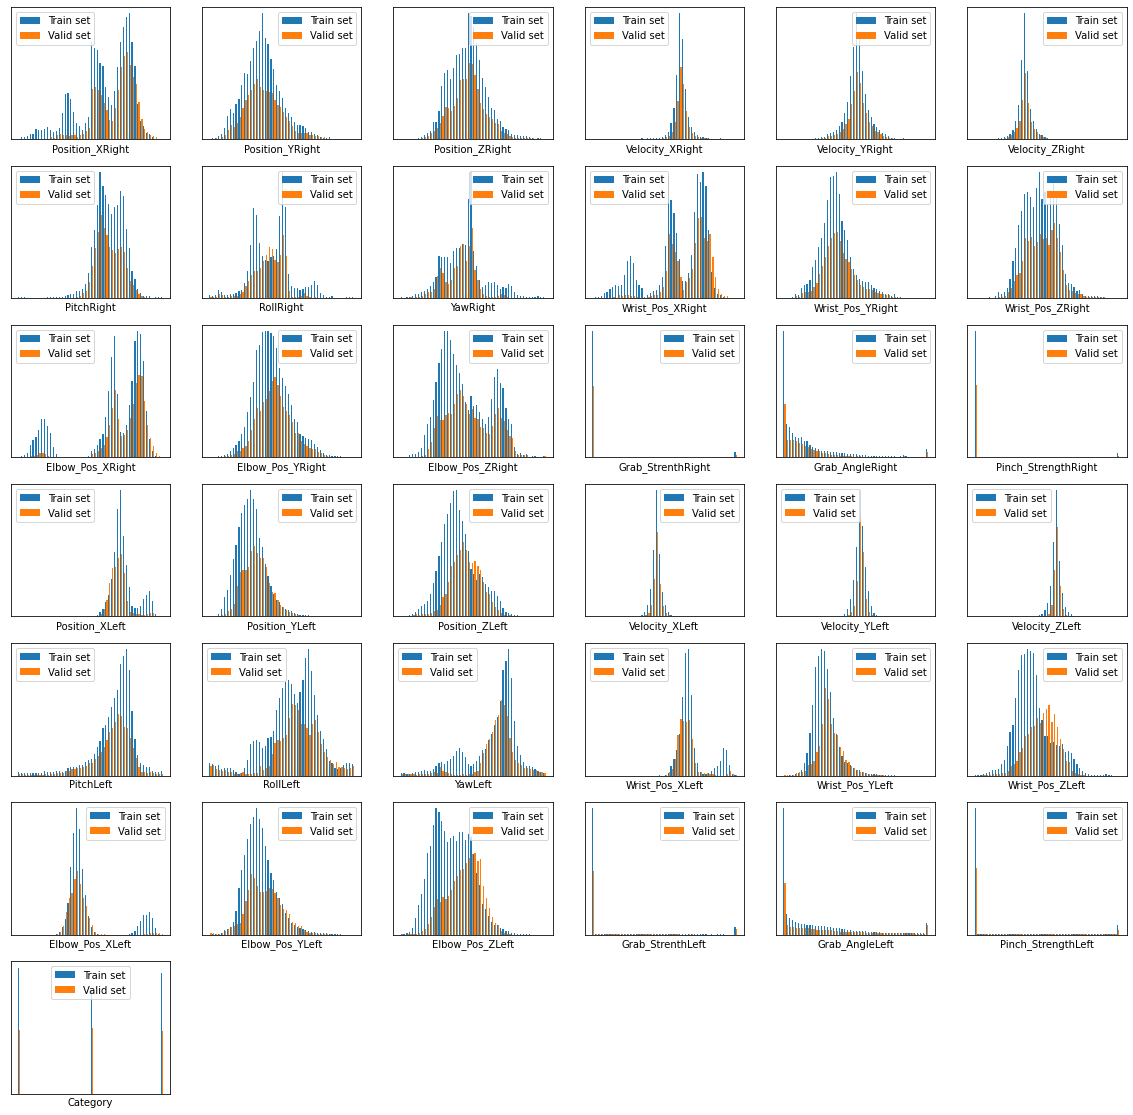

In [108]:
plt.figure(figsize=(20,20))
for i in range(len(train.columns)):
    plt.subplot(7,6,i+1)
    plt.hist(x=[train[train.columns[i]],valid[valid.columns[i]]], bins=50)
    plt.legend(['Train set','Valid set'])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(train.columns[i])
plt.show()

It seems by the patterns of the data, at least most of the times.

#### Correlation heatmap
Lets see the correation of each feature with the others:

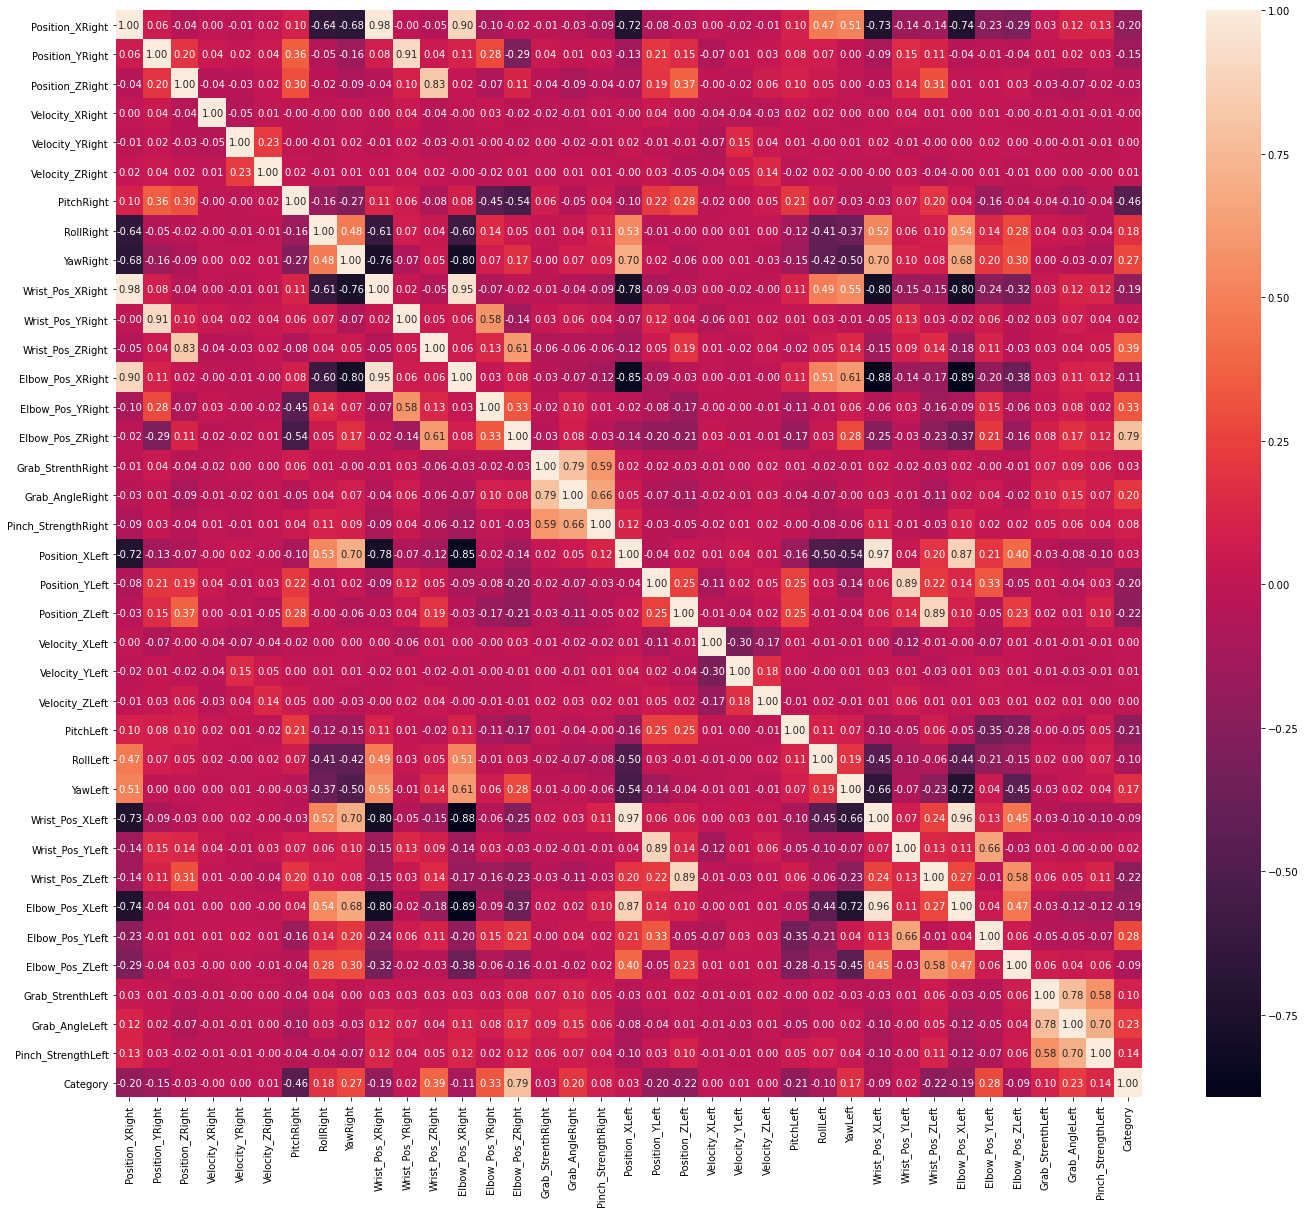

In [109]:
plt.figure(figsize=(23,20))
sns.heatmap(train.corr(), annot=True, fmt=".2f")
plt.show()

# Models

In [110]:
x_train = train.drop(columns='Category')
y_train = train.Category

x_test = test.drop(columns='Category')
y_test = test.Category

x_valid = valid.drop(columns='Category')
y_valid = valid.Category

## 'weak' learners

### KNN

runtime: 394.49579429626465 seconds


Text(0, 0.5, 'Testing Accuracy')

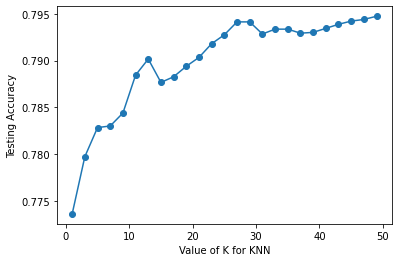

In [111]:
k_range = list(range(1, 51, 2))
scores = []
start=time.time()
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(x_train,y_train)
    pred = knn.predict(x_test)
    scores.append(metrics.accuracy_score(y_test, pred))
end=time.time()
print('runtime:',end - start, 'seconds')
plt.plot(k_range, scores, marker='o')
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

### Decision Tree

In [112]:
# Decision Tree
start = time.time()
dct = DecisionTreeClassifier(random_state=0)
dct.fit(x_train,y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 1.5111024379730225 seconds


### Logistic Regression

In [113]:
# Logistic Regression
start = time.time()
logreg = LogisticRegression(solver='saga',max_iter=200, n_jobs=-1)
logreg.fit(x_train,y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 6.317192554473877 seconds


## Ensemble learning

### Random Forest

In [114]:
# Random Forest
start = time.time()
rnd = RandomForestClassifier(random_state=42, n_estimators=150, n_jobs=-1)
rnd.fit(x_train,y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 4.282506227493286 seconds


### Hard Voting

In [115]:
# Voting
start = time.time()
hard_voting = VotingClassifier(voting='hard', estimators=[('logreg',logreg),('dct',dct),('knn',knn),('rnd',rnd)], n_jobs=-1)
hard_voting.fit(x_train, y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 11.194505453109741 seconds


### Soft Voting

In [116]:
# Voting
start = time.time()
soft_voting = VotingClassifier(voting='soft', estimators=[('logreg',logreg),('dct',dct),('knn',knn),('rnd',rnd)], n_jobs=-1)
soft_voting.fit(x_train, y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 10.875932216644287 seconds


### Stacking

In [117]:
# Stacking 
start = time.time()
stacking = StackingClassifier(estimators=[('logreg',logreg),('dct',dct),('knn',knn),('rnd',rnd)], n_jobs=-1)
stacking.fit(x_train, y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 53.03152251243591 seconds


## Boosting

### Adaboost

In [118]:
# Adaboost
start = time.time()
adaboost = AdaBoostClassifier(base_estimator=rnd)
adaboost.fit(x_train, y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 4.60090446472168 seconds


### Gradient Boosting

In [119]:
# Gradientboost
start = time.time()
gradient = GradientBoostingClassifier()
gradient.fit(x_train, y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 111.6031904220581 seconds


### XGBoost

In [120]:
#XGBoost
start = time.time()
xgboost = XGBClassifier(eval_metric='mlogloss', n_jobs=-1)
xgboost.fit(x_train, y_train)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 13.13371753692627 seconds


## Clustering

### Kmeans

In [122]:
# K-means
start = time.time()
k = 2
kmeans = KMeans(n_clusters=k, init='random', n_init=30)
kmeans.fit(x_train, y_train)
y_pred = kmeans.predict(x_test)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 38.63684678077698 seconds


In [132]:
start = time.time()
for model in [knn, dct, logreg, rnd, hard_voting, soft_voting, stacking, adaboost, gradient, xgboost]:
    print(model.__class__.__name__,"    ", model.score(x_test,y_test))
end = time.time()
print('runtime:',end - start, 'seconds')

KNeighborsClassifier      0.7947391116860716
DecisionTreeClassifier      0.8257869771453212
LogisticRegression      0.8197498921949116
RandomForestClassifier      0.896248382923674
VotingClassifier      0.871237602414834
VotingClassifier      0.8626994394135403
StackingClassifier      0.8755498059508409
AdaBoostClassifier      0.8828805519620526
GradientBoostingClassifier      0.9017680034497628
XGBClassifier      0.9141009055627426
runtime: 52.50252985954285 seconds


In [140]:
print('Kmeans')
print(classification_report(y_test,y_pred))

Kmeans
              precision    recall  f1-score   support

           0       0.34      0.50      0.40      3879
           1       0.34      0.52      0.41      3823
           2       0.00      0.00      0.00      3893

    accuracy                           0.34     11595
   macro avg       0.23      0.34      0.27     11595
weighted avg       0.23      0.34      0.27     11595



XGBoost is the best model. lets fine-tune it to have even better accuracy.

In [164]:
#XGBoost
start = time.time()
m = 0
k = 0
maximum = 0
for i in [0.1,0.3,0.5]:
    for j in [50,100,150]:
        xgboost = XGBClassifier(eval_metric='mlogloss', learning_rate=i, n_estimators=j, n_jobs=-1)
        xgboost.fit(x_train, y_train)
        score = xgboost.score(x_test,y_test)
        print('learning_rate:',i,', n_estimators:',j,'-',score)
        if score>maximum:
            m = i
            k = j
            maximum = score
end = time.time()
print('runtime:',end - start, 'seconds')

learning_rate: 0.1 , n_estimators: 50 - 0.8829667960327727
learning_rate: 0.1 , n_estimators: 100 - 0.9036653730056059
learning_rate: 0.1 , n_estimators: 150 - 0.9082363087537731
learning_rate: 0.3 , n_estimators: 50 - 0.9140146614920224
learning_rate: 0.3 , n_estimators: 100 - 0.9141009055627426
learning_rate: 0.3 , n_estimators: 150 - 0.9189305735230703
learning_rate: 0.5 , n_estimators: 50 - 0.9084950409659336
learning_rate: 0.5 , n_estimators: 100 - 0.9153945666235447
learning_rate: 0.5 , n_estimators: 150 - 0.9180681328158689
runtime: 120.4940333366394 seconds


### Best model

In [165]:
#XGBoost
start = time.time()
xgboost = XGBClassifier(eval_metric='mlogloss', learning_rate=m, n_estimators=k, n_jobs=-1)
xgboost.fit(x_train, y_train)
pred = xgboost.predict(x_valid)
end = time.time()
print('learning_rate =',m,'n_estimators =',k)
print('runtime:',end - start, 'seconds')

learning_rate = 0.3 n_estimators = 150
runtime: 17.92901301383972 seconds


score validation:

In [166]:
print(classification_report(y_valid,pred))

              precision    recall  f1-score   support

           0       0.89      0.68      0.77      9957
           1       0.77      0.92      0.84     10181
           2       0.96      1.00      0.98      9751

    accuracy                           0.87     29889
   macro avg       0.88      0.87      0.86     29889
weighted avg       0.87      0.87      0.86     29889



accuracy is 87%.

# PCA

In [167]:
start = time.time()
pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
end = time.time()
print('runtime:',end - start, 'seconds')

runtime: 0.05399346351623535 seconds


Text(0, 0.5, 'variance preserved')

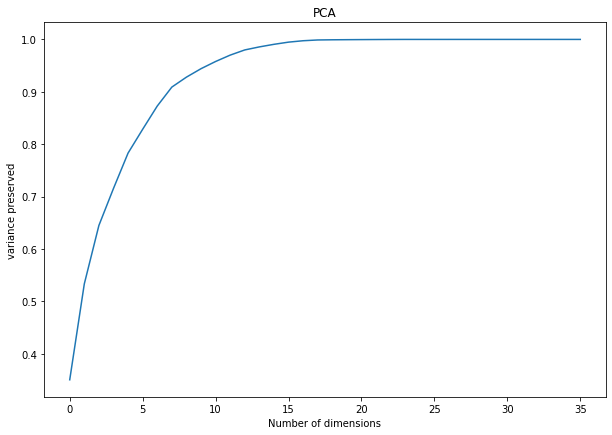

In [168]:
fig = plt.figure()
axes = fig.add_axes([0,0,1.3,1.3])
plt.plot(cumsum)
plt.title('PCA')
plt.xlabel('Number of dimensions')
plt.ylabel('variance preserved')

We will preserve 99% of the variance:

In [169]:
print('number of dimensions:',np.argmax(cumsum >= 0.99))

number of dimensions: 14


In [170]:
pca = PCA(n_components=0.99)
x1_reduced = pca.fit_transform(x_train)
x2_reduced = pca.transform(x_test)
x3_reduced = pca.transform(x_valid)

In [179]:
#XGBoost
start = time.time()
m = 0
k = 0
maximum = 0
for i in [0.1,0.3,0.5]:
    for j in [50,100,150]:
        xgboost = XGBClassifier(eval_metric='mlogloss', learning_rate=i, n_estimators=j, n_jobs=-1)
        xgboost.fit(x1_reduced, y_train)
        score = xgboost.score(x2_reduced,y_test)
        print('learning_rate:',i,', n_estimators:',j,'-',score)
        if score>maximum:
            m = i
            k = j
            maximum = score
end = time.time()
print('runtime:',end - start, 'seconds')

learning_rate: 0.1 , n_estimators: 50 - 0.691936179387667
learning_rate: 0.1 , n_estimators: 100 - 0.7135834411384218
learning_rate: 0.1 , n_estimators: 150 - 0.7206554549374731
learning_rate: 0.3 , n_estimators: 50 - 0.7164294954721863
learning_rate: 0.3 , n_estimators: 100 - 0.7218628719275549
learning_rate: 0.3 , n_estimators: 150 - 0.7235015092712376
learning_rate: 0.5 , n_estimators: 50 - 0.7235877533419578
learning_rate: 0.5 , n_estimators: 100 - 0.7305735230702889
learning_rate: 0.5 , n_estimators: 150 - 0.7314359637774903
runtime: 83.46816110610962 seconds


### Best Model
After PCA:

In [180]:
#XGBoost
start = time.time()
xgboost = XGBClassifier(eval_metric='mlogloss', learning_rate=m, n_estimators=k, n_jobs=-1)
xgboost.fit(x1_reduced, y_train)
pred = xgboost.predict(x3_reduced)
end = time.time()
print('learning_rate =',m,'n_estimators =',k)
print('runtime:',end - start, 'seconds')

learning_rate = 0.5 n_estimators = 150
runtime: 11.778008937835693 seconds


In [181]:
print(classification_report(y_valid,pred))

              precision    recall  f1-score   support

           0       0.70      0.64      0.67      9957
           1       0.69      0.74      0.72     10181
           2       0.97      0.99      0.98      9751

    accuracy                           0.79     29889
   macro avg       0.79      0.79      0.79     29889
weighted avg       0.79      0.79      0.79     29889



Interesting, the validation accuracy is higher than the test accuracy.  
### We lost about 9% for using about half of the features. Is it a good deal? Probably not.